In [4]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import pysindy as ps

In [5]:
omega = 1.00

def SHO (t, y):
    x, v = y
    dxdt = v 
    dvdt = -omega**2 * x 
    return [dxdt, dvdt]

In [6]:
y0 = [1.0 , 1.0]
t_span = (0, 10)
t_eval = np.linspace(t_span[0], t_span[1], 1000)

solution_sho = solve_ivp (SHO, t_span, y0, t_eval=t_eval)

In [7]:
# solve diffusion pde

numx = 101
numt = 2001
Lx = 1.0
Tf = 0.1
dx = Lx / (numx-1)
dt = Tf / (numt-1)

x = np.arange(0, Lx + dx, dx)
t = np.arange(0, Tf + dt, dt)

phi = np.zeros((numx, numt))

mu = 0.5
sigma = 0.05
phi[:, 0] = np.exp( -(x - mu)**2/(2 * sigma**2)) / np.sqrt(2 * np.pi * sigma**2)

In [8]:
for j in np.arange(0, numt-1): 
    for i in np.arange(1, numx-1): 
        phi[i, j+1] = phi[i, j] + (dt/dx**2) * (phi[i+1, j] - 2*phi[i, j] + phi[i-1, j])
    phi[0, j+1] = phi[1, j+1]    
    phi[numx-1, j+1] = phi[numx-2, j+1]

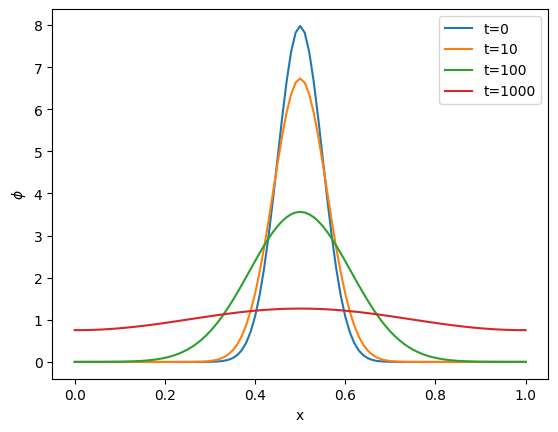

In [9]:
plt.plot(x , phi[:,0], label='t=0')
plt.plot(x, phi[:, 10], label='t=10')
plt.plot(x, phi[:, 100], label='t=100')
plt.plot(x, phi[:, 1000], label='t=1000')
plt.xlabel('x')
plt.ylabel('$\phi$')
plt.legend()
plt.show()

In [10]:
print(f'$\phi$ shape={phi.shape}')
print(f'x shape={x.shape}')
print(f't shape={t.shape}')

$\phi$ shape=(101, 2001)
x shape=(101,)
t shape=(2001,)


In [11]:
phi_dot = ps.FiniteDifference(axis=1)._differentiate(phi, t=dt)

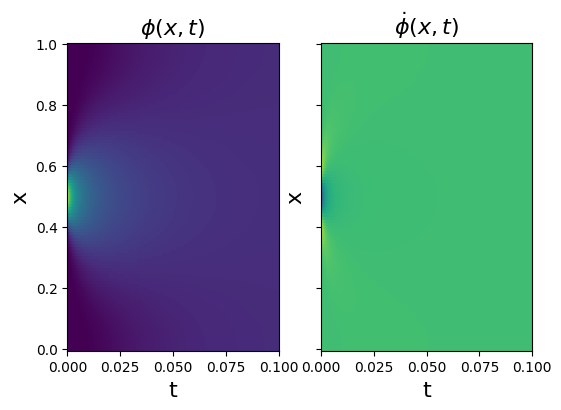

In [12]:
dt = t[1] - t[0]
dx = x[1] - x[0]

# Plot phi and phi_dot
plt.figure(figsize=(6, 4))
plt.subplot(1, 2, 1)
plt.pcolormesh(t, x, phi)
plt.xlabel('t', fontsize=16)
plt.ylabel('x', fontsize=16)
plt.title(r'$\phi(x, t)$', fontsize=16)

plt.subplot(1, 2, 2)
plt.pcolormesh(t, x, phi_dot)
plt.xlabel('t', fontsize=16)
plt.ylabel('x', fontsize=16)
ax = plt.gca()
ax.set_yticklabels([])
plt.title(r'$\dot{\phi}(x, t)$', fontsize=16)
plt.show()

In [13]:
phi_ps = phi[:,:,np.newaxis]
print(phi_ps.shape)

(101, 2001, 1)


In [14]:

pde_lib = ps.PDELibrary(
    function_library=ps.PolynomialLibrary(degree=2,include_bias=False),
    derivative_order=3,
    spatial_grid=x,
    is_uniform=True,
)

print('STLSQ model: ')
optimizer = ps.STLSQ(threshold=1, alpha=1e-5, )#normalize_columns=True)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(phi_ps, t=dt)
model.print()

print('SR3 model, L0 norm: ')
optimizer = ps.SR3(
    threshold=2,
    max_iter=10000,
    tol=1e-15,
    nu=1e2,
    thresholder="l0",
    #normalize_columns=True,
)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(phi_ps, t=dt)
model.print()

print('SR3 model, L1 norm: ')
optimizer = ps.SR3(
    threshold=0.5, max_iter=10000, tol=1e-15, 
    thresholder="l1", normalize_columns=True
)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(phi_ps, t=dt)
model.print()

print('SSR model: ')
optimizer = ps.SSR(kappa=1) #normalize_columns=True, 
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(phi_ps, t=dt)
model.print()

print('SSR (metric = model residual) model: ')
optimizer = ps.SSR(criteria="model_residual", 
                   #normalize_columns=True, 
                   kappa=1)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(phi_ps, t=dt)
model.print()

print('FROLs model: ')
optimizer = ps.FROLS(kappa=1e-3) #normalize_columns=True, 
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(phi_ps, t=dt)
model.print()

STLSQ model: 
(x0)' = 1.016 x0_11
SR3 model, L0 norm: 
(x0)' = 0.000
SR3 model, L1 norm: 
(x0)' = -1.155 x0 + 1.010 x0^2 + 1.001 x0_11 + 0.013 x0x0_11 + -0.001 x0^2x0_11
SSR model: 
(x0)' = 0.172 x0^2 + 1.019 x0_11
SSR (metric = model residual) model: 
(x0)' = 1.006 x0_11 + 0.002 x0x0_11
FROLs model: 
(x0)' = 0.000


Adding noise to data

In [15]:
eta_list = np.array([0., 0.01, 0.05, 0.1, 0.2])

phi_noisy = np.array([phi_ps + eta * np.random.random(phi_ps.shape) for eta in eta_list])

phi_noisy_dot = ps.SmoothedFiniteDifference(axis=1)._differentiate(phi_noisy[1], t=dt)

In [16]:
phi_noisy.shape

(5, 101, 2001, 1)

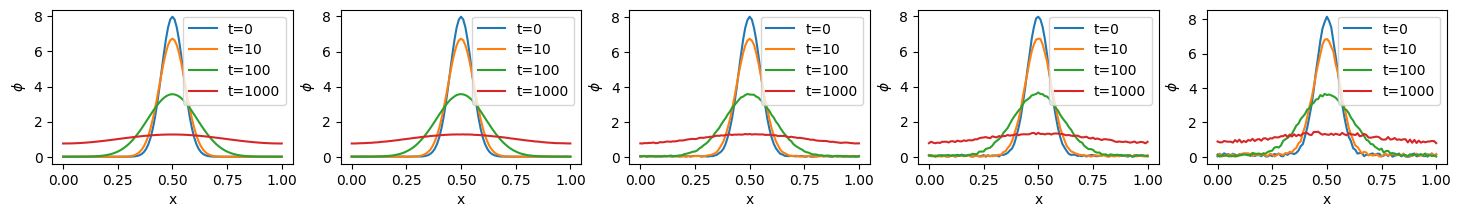

In [17]:
fig, axs = plt.subplots(1,len(eta_list), figsize = (18,2))
for i in range(len(eta_list)): 
    axs[i].plot(x , phi_noisy[i, :,0], label='t=0')
    axs[i].plot(x, phi_noisy[i, :, 10], label='t=10')
    axs[i].plot(x, phi_noisy[i, :, 100], label='t=100')
    axs[i].plot(x, phi_noisy[i, :, 1000], label='t=1000')
    axs[i].set_xlabel('x')
    axs[i].set_ylabel('$\phi$')
    axs[i].legend()

fig.show()

In [18]:
pde_lib = ps.PDELibrary(
    function_library=ps.PolynomialLibrary(degree=2, include_bias=False),
    derivative_order=2,
    spatial_grid=x,
    is_uniform=True,
)


print('STLSQ model: ')
optimizer = ps.STLSQ(threshold=1, alpha=1e-3, )#normalize_columns=True)

for i in range(len(eta_list)):
    phi_noisy_dot = ps.SmoothedFiniteDifference(axis=1)._differentiate(phi_noisy[i], t=dt)
    model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer, 
                     differentiation_method=ps.SINDyDerivative(kind="trend_filtered", order=0, alpha=1e-5))
    model.fit(phi_noisy[i], t=dt,) #x_dot = phi_noisy_dot)
    model.print()

STLSQ model: 
(x0)' = 200.000 x0_1
(x0)' = 200.000 x0_1
(x0)' = 200.000 x0_1
(x0)' = 200.000 x0_1
(x0)' = 200.000 x0_1


In [19]:
print('SR3 model, L0 norm: ')
optimizer = ps.SR3(
    threshold=1,
    max_iter=10000,
    tol=1e-15,
    nu=1e2,
    thresholder="l0",
    #normalize_columns=True,
)

for i in range(len(eta_list)):
    phi_noisy_dot = ps.SmoothedFiniteDifference(axis=1)._differentiate(phi_noisy[i], t=dt)
    model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
    model.fit(phi_noisy[i], t=dt,) #x_dot = phi_noisy_dot)
    model.print()

SR3 model, L0 norm: 
(x0)' = -1.186 x0 + 1.035 x0^2 + 1.000 x0_11
(x0)' = 16.050 x0 + -12.131 x0^2
(x0)' = 34.630 x0 + -26.947 x0^2
(x0)' = 40.960 x0 + -31.110 x0^2
(x0)' = 45.889 x0 + -33.649 x0^2


In [56]:
print('SR3 model, L1 norm: ')
optimizer = ps.SR3(
    threshold=1, max_iter=10000, tol=1e-15, 
    thresholder="l1", normalize_columns=True
)

for i in range(len(eta_list)):
    phi_noisy_dot = ps.SmoothedFiniteDifference(axis=1)._differentiate(phi_noisy[i], t=dt)
    model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
    model.fit(phi_noisy[i], t=dt,) #x_dot = phi_noisy_dot)
    model.print()

SR3 model, L1 norm: 
(x0)' = -1.124 x0 + 0.985 x0^2 + 1.001 x0_11 + 0.012 x0x0_11 + -0.001 x0^2x0_11
(x0)' = 16.100 x0 + -12.164 x0^2 + 0.100 x0_1 + 0.066 x0_11 + -0.123 x0x0_1 + 0.033 x0^2x0_1 + 0.189 x0x0_11 + -0.012 x0^2x0_11
(x0)' = 33.550 x0 + -26.133 x0^2 + 0.021 x0_1 + 0.008 x0_11 + 0.096 x0x0_1 + -0.035 x0^2x0_1 + -0.011 x0x0_11 + 0.012 x0^2x0_11
(x0)' = 39.654 x0 + -30.125 x0^2 + 0.852 x0_1 + 0.012 x0_11 + -0.570 x0x0_1 + 0.084 x0^2x0_1 + -0.023 x0x0_11 + 0.011 x0^2x0_11
(x0)' = 45.367 x0 + -33.287 x0^2 + -1.942 x0_1 + 0.010 x0_11 + 1.670 x0x0_1 + -0.310 x0^2x0_1 + -0.018 x0x0_11 + 0.006 x0^2x0_11


In [20]:
print('SSR (metric = model residual) model: ')
optimizer = ps.SSR(criteria="model_residual", 
                   #normalize_columns=True, 
                   kappa=1)

for i in range(len(eta_list)):
    model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
    model.fit(phi_noisy[i], t=dt)
    model.print()

SSR (metric = model residual) model: 
(x0)' = -1.186 x0 + 1.035 x0^2 + 1.000 x0_11 + 0.013 x0x0_11 + -0.001 x0^2x0_11
(x0)' = 16.050 x0 + -12.131 x0^2 + 0.063 x0_11 + -0.004 x0x0_1 + 0.191 x0x0_11 + -0.012 x0^2x0_11
(x0)' = 34.630 x0 + -26.947 x0^2 + -0.132 x0_1 + 0.011 x0_11 + 0.075 x0x0_1 + 0.001 x0^2x0_1 + -0.012 x0x0_11 + 0.012 x0^2x0_11
(x0)' = 40.961 x0 + -31.111 x0^2 + 0.167 x0_1 + 0.013 x0_11 + -0.008 x0x0_1 + -0.023 x0x0_11 + 0.009 x0^2x0_11
(x0)' = 45.889 x0 + -33.649 x0^2 + -0.578 x0_1 + 0.013 x0_11 + 0.520 x0x0_1 + -0.081 x0^2x0_1 + -0.020 x0x0_11 + 0.006 x0^2x0_11


In [21]:
print('FROLs model: ')
optimizer = ps.FROLS(kappa=1e-5, normalize_columns=True)

for i in range(len(eta_list)):
    model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
    model.fit(phi_noisy[i], t=dt)
    model.print()

FROLs model: 
(x0)' = 1.016 x0_11
(x0)' = 16.050 x0 + -12.131 x0^2 + 0.063 x0_11 + 0.191 x0x0_11 + -0.012 x0^2x0_11
(x0)' = 34.615 x0 + -26.851 x0^2 + 0.010 x0^2x0_11
(x0)' = 43.271 x0 + -32.507 x0^2 + 0.005 x0^2x0_11
(x0)' = 52.709 x0 + -38.167 x0^2


In [37]:
X, T = np.meshgrid(x, t)
XT = np.asarray([X, T]).T
pde_lib = ps.WeakPDELibrary(
#     library_functions=library_functions,
#     function_names=library_function_names,
    function_library=ps.PolynomialLibrary(degree=2,include_bias=False),
    derivative_order=2,
    spatiotemporal_grid=XT,
    is_uniform=True,
    K=10000,
    include_bias=True,
)

In [38]:
print('Weak form, SR3: ')

optimizer = ps.SR3(threshold=0.1, 
                   thresholder="l0", 
                   tol=1e-8, 
                   normalize_columns=True, 
                   max_iter=1000)
np.random.seed(1)

for i in range(len(eta_list)):
    model = ps.SINDy(feature_library=pde_lib, 
                     optimizer=optimizer,
                     differentiation_method=ps.SmoothedFiniteDifference(),
                      )
    model.fit(phi_noisy[i], t=dt)
    model.print()

Weak form, SR3: 
(x0)' = 1.002 x0_11
(x0)' = 1.001 x0_11
(x0)' = 0.989 x0_11
(x0)' = 0.952 x0_11
(x0)' = 17.637 1 + -14.858 x0 + 0.649 x0_11


In [34]:
print('Weak form, SR3, L0: ')

optimizer = ps.SR3(threshold=.5, thresholder="l0", tol=1e-8, normalize_columns=False, max_iter=1000)
np.random.seed(1)

for i in range(len(eta_list)):
    model = ps.SINDy(feature_library=pde_lib, 
                     optimizer=optimizer,
                      differentiation_method=ps.SmoothedFiniteDifference(),
                      )
    model.fit(phi_noisy[i], t=dt)
    model.print()

Weak form, SR3: 
(x0)' = 1.002 x0_11
(x0)' = 1.002 x0_11
(x0)' = 0.713 x0 + -0.781 x0^2 + 0.972 x0_11
(x0)' = 4.788 1 + -1.866 x0 + -2.100 x0^2 + 0.858 x0_11
(x0)' = 8.571 1 + -6.388 x0^2 + 1.167 x0_1 + 0.603 x0_11 + -0.849 x0x0_1


In [53]:
print('Weak form, SR3 model, L1 norm: ')

X, T = np.meshgrid(x, t)
XT = np.asarray([X, T]).T
pde_lib = ps.WeakPDELibrary(
#     library_functions=library_functions,
#     function_names=library_function_names,
    function_library=ps.PolynomialLibrary(degree=2,include_bias=False),
    derivative_order=2,
    spatiotemporal_grid=XT,
    is_uniform=True,
    K=1000,
    include_bias=True,
)

optimizer = ps.SR3(
    threshold=0.01, max_iter=1000, tol=1e-8, 
    thresholder="l1", normalize_columns=True
)

for i in range(len(eta_list)):
    model = ps.SINDy(feature_library=pde_lib, 
                     optimizer=optimizer,
                      differentiation_method=ps.SmoothedFiniteDifference(),
                      )
    model.fit(phi_noisy[i], t=dt)
    model.print()

SR3 model, L1 norm: 
(x0)' = 0.739 x0_11
(x0)' = 0.738 x0_11
(x0)' = 0.727 x0_11
(x0)' = 0.697 x0_11
(x0)' = 0.585 x0_11


In [60]:
print('Weak form, FROLS model: ')

X, T = np.meshgrid(x, t)
XT = np.asarray([X, T]).T
pde_lib = ps.WeakPDELibrary(
#     library_functions=library_functions,
#     function_names=library_function_names,
    function_library=ps.PolynomialLibrary(degree=2,include_bias=False),
    derivative_order=3,
    spatiotemporal_grid=XT,
    is_uniform=True,
    K=1000,
    include_bias=True,
)

optimizer = ps.FROLS(kappa=1e-4, normalize_columns=True, verbose=False)

for i in range(len(eta_list)):
    model = ps.SINDy(feature_library=pde_lib, 
                     optimizer=optimizer,
                      differentiation_method=ps.SmoothedFiniteDifference(),
                      )
    model.fit(phi_noisy[i], t=dt)
    model.print()

Weak form, FROLS model: 
(x0)' = 1.002 x0_11
(x0)' = 1.002 x0_11
(x0)' = 0.996 x0_11
(x0)' = 0.984 x0_11
(x0)' = 0.933 x0_11


In [58]:


print('Weak form, STLSQ model: ')

X, T = np.meshgrid(x, t)
XT = np.asarray([X, T]).T
pde_lib = ps.WeakPDELibrary(
#     library_functions=library_functions,
#     function_names=library_function_names,
    function_library=ps.PolynomialLibrary(degree=2,include_bias=False),
    derivative_order=3,
    spatiotemporal_grid=XT,
    is_uniform=True,
    K=1000,
    include_bias=True,
)

optimizer = ps.STLSQ(threshold=.1, alpha=1e-3, )

for i in range(len(eta_list)):
    model = ps.SINDy(feature_library=pde_lib, 
                     optimizer=optimizer,
                      differentiation_method=ps.SmoothedFiniteDifference(),
                      )
    model.fit(phi_noisy[i], t=dt)
    model.print()

Weak form, FROLS model: 
(x0)' = 1.002 x0_11
(x0)' = 1.001 x0_11
(x0)' = 0.994 x0_11
(x0)' = 0.899 x0_11 + 0.032 x0x0_11
(x0)' = 0.886 x0_11
